In [47]:
import pandas as pd
import os
from tqdm import tqdm
import pydicom
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
import segmentation_models_pytorch as smp
from torch.cuda.amp import autocast

In [2]:
df = pd.read_excel('/data_vault/hexai02/CarpalTunnel/AI Project Data Clean 10-8.xlsx')

In [3]:
df.head(100)

,Number,WristImage Segmentation for AI Analysis,Arm (L/R),Sex,Race,Ethnicity,Age,Clinical Signs of CTS,CTS-6 Score,Measurement at Wrist
0,21,Yes,R,M,White,Non-Hispanic,43.0,Y,12.5,12.16
1,22,Yes,R,M,White,Unreported/Chose not to disclose,74.0,Y,16.5,20.10
2,23,Yes,L,M,White,Unreported/Chose not to disclose,74.0,Y,11.5,13.83
3,24,Yes,R,F,Black,Non-Hispanic,63.0,Y,21.0,16.55
4,25,Yes,R,M,White,Non-Hispanic,49.0,Y,9.0,19.21
...,...,...,...,...,...,...,...,...,...,...
95,163,Yes,R,F,White,Non-Hispanic,74.0,?,NaN,12.78
96,164,Yes,R,F,Black,Non-Hispanic,67.0,N,3.5,7.57
97,165,yes,R,F,White,Non-Hispanic,65.0,N,0.0,16.10
98,166,Yes,L,F,White,Non-Hispanic,51.0,Y,16.5,9.95


In [4]:
df['Clinical Signs of CTS'].unique()

array(['Y', 'N', 'Yes', '?'], dtype=object)

In [5]:
df['Clinical Signs of CTS'] = df['Clinical Signs of CTS'].replace('Yes', 'Y')

In [6]:
df['Clinical Signs of CTS'].unique()

array(['Y', 'N', '?'], dtype=object)

In [7]:
count_question_mark = (df['Clinical Signs of CTS'] == '?').sum()
print(count_question_mark)

1


In [14]:
restructured_root = 'data_yolo'
image_dir = os.path.join(restructured_root, 'images')
image_train_dir = os.path.join(image_dir, 'train')
image_val_dir = os.path.join(image_dir, 'val')
image_test_dir = os.path.join(image_dir, 'test')
label_dir = os.path.join(restructured_root, 'labels')
label_train_dir = os.path.join(label_dir, 'train')
label_val_dir = os.path.join(label_dir, 'val')

In [15]:
anno_dir = '/data_vault/hexai02/CarpalTunnel/Annotations'
dicom_dir = '/data_vault/hexai02/CarpalTunnel/Images'

In [16]:
def load_mask(mask_path):
    mask = sitk.ReadImage(mask_path)
    return sitk.GetArrayFromImage(mask)[0][: 450, 200: 1300]

def load_dicom(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    return dicom_data.pixel_array[: 450, 200: 1300]

In [24]:
model = YOLO("runs/detect/train17/weights/best.pt")
model.eval()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [6]:
config = {
    'epochs': 40,
    'in_channels': 1,
    'dropout': 0.2,
    'decoder_attention_type': 'scse',
    'init_lr': 5e-4,
    'weight_decay': 0.05,
    'T_max': 10,
    'eta_min': 3e-5
}

In [7]:
def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    return model, optimizer, scheduler, epoch

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"

unet_model = smp.Unet(encoder_name="resnet18",in_channels=1,dropout=config['in_channels'],decoder_attention_type=config['decoder_attention_type']).to(device)

unet_model, _, _, _ = load_model(unet_model, optimizer=None, scheduler=None, path=f'unet_runs/epoch_39.pth')
unet_model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

  0%|                                                                                                                                                                                | 0/87 [00:00<?, ?it/s]


0: 480x1120 1 ulnar, 7.8ms
Speed: 3.7ms preprocess, 7.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1120)


/tmp/ipykernel_3507993/301801285.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|                                                                                                                                                                                | 0/33 [00:00<?, ?it/s]


0: 480x1120 1 ulnar, 6.8ms
Speed: 2.9ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


  0%|                                                                                                                                                                                | 0/33 [00:00<?, ?it/s]


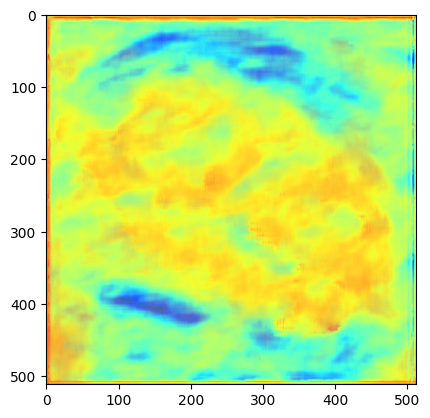

In [49]:
train_images = []
train_labels = []
val_images = []
val_labels = []

import cv2
image_transform = T.Compose([
    T.Normalize(mean=[0.5], std=[0.5]),
    T.Resize((512, 512), interpolation=T.InterpolationMode.BILINEAR),
])

def fill_arr(img_dir, img_bucket, mask_bucket):
    for jpg_name in tqdm(os.listdir(img_dir)): 
        entry_name = jpg_name.split('.')[0]
        img_filename = entry_name + '.dcm'
        # mask_filename = jpg_name.split('.')[0] + '.nii.gz'
        
        img = load_dicom(os.path.join(dicom_dir, img_filename))
        # mask = load_mask(os.path.join(anno_dir, mask_filename))
       
        result = model(img, save=False)
        box = result[0].boxes
        
        if len(box.xyxy.tolist())== 0:
            continue
        x1, y1, x2, y2 = map(int, box.xyxy.tolist()[0])
        img_slice = img[y1:y2, x1:x2, 0]
        # img_resized = cv2.resize(img_slice, (512, 512))

        img_tensor = torch.from_numpy(img_slice).float()  # Convert to float tensor
        

        # Add batch and channel dimensions if needed (for model input)
        img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 512, 512)

        
        # Send to device
        img_tensor = img_tensor.to(device)
        img_tensor = image_transform(img_tensor)

        img_resized = img_tensor.squeeze().cpu().detach().numpy()
        with torch.no_grad():
            with autocast():
                mask_gpu = unet_model(img_tensor)
        mask = mask_gpu.squeeze().cpu().detach().numpy()
        # mask = (mask > 0.5).astype(np.uint8)

        img_2channel = np.stack((img_resized, mask), axis=2)
        # plt.imshow(img_2channel[:,:,0], cmap="gray", alpha=0.6)
        plt.imshow(img_2channel[:,:,1], cmap="jet", alpha=0.6)
        break
        
        # img_bucket.append(img[y1:y2, x1:x2, 0])
        # mask_bucket.append(mask[y1:y2, x1:x2])
        
        

fill_arr(image_train_dir, train_images, train_labels)
fill_arr(image_val_dir, val_images, val_labels)